In [109]:
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression as MIR
import tensorflow as tf


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [110]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# # days start interval
# SURVIVAL_CATEGORIES= {
#     'SHORT' : 0 , # 0-300
#     'MEDIUM' : 250,  # 300-450
#     'LONG' : 450, # 450 and more
# }

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH='./MICCAI_BraTS2020_TrainingData/'
VAL_DATASET_PATH='./MICCAI_BraTS2020_ValidationData/'

In [111]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories+= [f.path for f in os.scandir(VAL_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)

In [112]:
import csv

csvs = [r'MICCAI_BraTS2020_TrainingData/survival_info.csv', r'MICCAI_BraTS2020_ValidationData/survival_evaluation.csv']

age_dict = {}
days_dict = {}
at_line = 0
category_short = 0
category_medium = 0
category_long = 0
max_days = 0
for csv_path in csvs:
    with open(csv_path, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file,delimiter = ',')
    #  row_count = sum(1 for row in csv_reader)
    #   print(f'total rows: {row_count} .')
        for row in csv_reader:
            if at_line == 0:
                # print(f'Column names are {", ".join(row)}')
                at_line += 1
            else:
                if (row[-1] != "GTR"):
                    continue
                # print(row)
                key = row[0]
                age = row[1]
                days = row[2]
                age_dict[key] = float(age)
                if (not days.isnumeric()):
                    continue
                days_dict[key] = int(days)
                max_days = max(max_days,int(days))
                if int(days) < 250:
                    category_short += 1
                elif (int(days) >= 250 and int(days) <= 450):
                    category_medium += 1
                else:
                    category_long += 1
                at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Processed 119 lines.
34 38 46
1767
Processed 119 lines.
34 38 46
1767


In [113]:
import csv

def col_and_eval(ch_ft = []):
    id_list2 = []
    csv_filenames = [r'./results.csv',r'./results_val.csv']
    dt =[]
    jj = [] #key_list
    id_tp = 0
    row_cc = 0
    row2 = {}
    id_check = {}
    for csv_filename in csv_filenames:
        with open(csv_filename) as f:
            reader = csv.DictReader(f)
            for row in reader:
                # if row_cc > 20:
                #     break
                # row_cc += 1
                dt_tp = row
                if row['Patient_ID'] not in id_check:
                    id_check[row['Patient_ID']] = 0
                id_check[row['Patient_ID']] += 1
                if len(id_list2) != 0:
                    if id_list2[-1] == row["Patient_ID"]:
                        id_tp += 1
                    else:
                        dt.append(row2)
                        row2 = {}
                        id_tp = 0
                if id_tp == 0:
                    id_list2.append(row["Patient_ID"])
                if len(id_list2) == 1:
                    for keysj in row:
                        if keysj != None:
                            if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                                continue
                            # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                            row[keysj] = eval(row[keysj])
                            if isinstance(row[keysj],tuple):
                                ct = 0
                                for it in row[keysj]:
                                    keysjn = keysj + str(ct)
                                    keysjn += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                                    if (keysjn in ch_ft) or (len(ch_ft) == 0):
                                        jj.append(keysjn)
                                    ct += 1
                                continue
                            keysj += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                            if (keysj in ch_ft) or (len(ch_ft) == 0):
                                jj.append(keysj)
                for keysj in row:
                    if keysj != None:
                        if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                            continue
                        # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                        row[keysj] = eval(str(row[keysj]))
                        keys2j = keysj + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                        if isinstance(row[keysj],tuple):
                            ct = 0
                            for it in row[keysj]:
                                keys2j =  keysj + str(ct) + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                                row2[keys2j] = it
                                ct += 1
                            continue
                        row2[keys2j] = row[keysj]
                row2['Patient_ID'] = row['Patient_ID']
    dt.append(row2)    
    return dt, jj

# print(jj)
# print(dt)
# create only age: category data


In [114]:
patlist_tr = []
patlist_val = []

# id: age, categories
def getListAgeDays(id_list, dt, jj, ch_ft = []):
    x_val = []
    y_val = []
    x_test = []
    for i in dt:
        if ((i["Patient_ID"] not in days_dict) and ("Validation" not in i["Patient_ID"])):
            # print(i["Patient_ID"])
            continue
        if (i["Patient_ID"] not in age_dict):
            continue
        j = [age_dict[i["Patient_ID"]]]
        for keysj in i:
            if keysj != None:
                if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                    continue
                if (keysj not in ch_ft) and (len(ch_ft) != 0):
                    continue
                # if(i[keysj][0]=='('):
                #     i[keysj] = tuple(i[keysj])
                # else:
                # print(i[keysj])
                # i[keysj] = eval(i[keysj])
                # if isinstance(i[keysj],tuple):
                #     ct = 0
                #     for it in i[keysj]:
                #         keysjn = keysj + str(ct)
                #         j.append(it)
                #         ct += 1
                #     continue
                j.append(i[keysj])
        # print(j)
        if "Validation" in i["Patient_ID"]:
            # print("vvv"+i["Patient_ID"])
            x_test.append(j)
            patlist_val.append(i["Patient_ID"])
        else:
            x_val.append(j) 
            y_val.append(days_dict[i["Patient_ID"]])
            patlist_tr.append(i["Patient_ID"])
        # if (days_dict[i["Patient_ID"]] < 250):
        #     y_val.append(0)
        # elif (days_dict[i["Patient_ID"]] >= 250 and days_dict[i["Patient_ID"]] < 450):
        #     y_val.append(1)
        # else:
        #     y_val.append(2)
            
    return np.array(x_val), np.array(y_val), np.array(x_test)

dt, jj = col_and_eval()
X_all, y_all, x_val = getListAgeDays(train_and_test_ids,dt,jj)
print(len(train_and_test_ids))
print(X_all.shape)
print(y_all.shape)
print(x_val.shape)
print(f'X_all: {X_all.shape}')
columns = ["age"]+jj+["prediction"]
print(columns)
dfn = np.concatenate((X_all, y_all[:,None]), axis=1)
print(dfn.shape,len(columns))
df = pd.DataFrame(dfn, columns = columns)
df2 = pd.DataFrame(x_val,columns = ["age"]+jj)
df2.head()

493
(117, 10701)
(117,)
(28, 10701)
X_all: (117, 10701)
['age', 'original_shape_Elongation_flair', 'original_shape_Flatness_flair', 'original_shape_LeastAxisLength_flair', 'original_shape_MajorAxisLength_flair', 'original_shape_Maximum2DDiameterColumn_flair', 'original_shape_Maximum2DDiameterRow_flair', 'original_shape_Maximum2DDiameterSlice_flair', 'original_shape_Maximum3DDiameter_flair', 'original_shape_MeshVolume_flair', 'original_shape_MinorAxisLength_flair', 'original_shape_Sphericity_flair', 'original_shape_SurfaceArea_flair', 'original_shape_SurfaceVolumeRatio_flair', 'original_shape_VoxelVolume_flair', 'original_firstorder_10Percentile_flair', 'original_firstorder_90Percentile_flair', 'original_firstorder_Energy_flair', 'original_firstorder_Entropy_flair', 'original_firstorder_InterquartileRange_flair', 'original_firstorder_Kurtosis_flair', 'original_firstorder_Maximum_flair', 'original_firstorder_MeanAbsoluteDeviation_flair', 'original_firstorder_Mean_flair', 'original_firsto

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,68.170,0.708109,0.549494,44.532841,81.043346,77.491935,89.944427,82.540899,91.181138,90802.87500,...,1.388889e-02,1.388889e-02,1.000000e+00,0.000022,2.063521e+09,0.0,1000000.0,0.0,0.0,0.0
1,50.153,0.713522,0.581695,28.423128,48.862599,48.662100,50.606324,42.011903,51.662365,19210.95833,...,2.700000e-09,2.700000e-09,-3.200000e-16,0.000052,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0
2,21.726,0.572874,0.488275,47.082522,96.426173,70.830784,110.367568,99.609237,110.742946,59501.04167,...,2.812822e-02,2.812822e-02,2.000000e+00,0.000067,6.654277e+08,0.0,1000000.0,0.0,0.0,0.0
3,55.482,0.647488,0.498546,45.320963,90.906282,70.576200,94.339811,94.085068,94.620294,99705.66667,...,1.676474e-01,1.676474e-01,2.584963e+00,0.000060,1.381898e+09,0.0,1000000.0,0.0,0.0,0.0
4,64.753,0.729476,0.516040,43.413481,84.128141,80.000000,84.403791,80.056230,87.464278,57203.79167,...,1.718748e-01,1.718748e-01,2.405639e+00,0.000140,3.572158e+08,0.0,1000000.0,0.0,0.0,0.0


In [115]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled
X_val = scaler.fit_transform(x_val)

df = pd.DataFrame(X_all, columns = ["age"]+jj)
# display(df)
df2 = pd.DataFrame(X_val,columns = ["age"]+jj)
df2.head()

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,0.726244,0.414664,0.554768,0.618613,0.703363,0.864464,0.717478,0.746378,0.730597,0.678942,...,2.777778e-02,2.777778e-02,0.356207,0.007783,0.804518,0.0,0.0,0.0,0.0,0.0
1,0.444512,0.427461,0.639311,0.213227,0.207936,0.257954,0.173298,0.144148,0.186348,0.103571,...,5.283200e-09,5.283200e-09,0.000000,0.024042,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.094908,0.394040,0.682773,0.940184,0.724329,1.000000,1.000000,1.000000,0.427375,...,5.625643e-02,5.625643e-02,0.712414,0.032172,0.259434,0.0,0.0,0.0,0.0,0.0
3,0.527842,0.271328,0.421005,0.638445,0.855204,0.718974,0.778281,0.917915,0.777960,0.750492,...,3.352948e-01,3.352948e-01,0.920782,0.028378,0.538769,0.0,0.0,0.0,0.0,0.0
4,0.672812,0.465184,0.466935,0.590445,0.750854,0.917228,0.640832,0.709457,0.679408,0.408912,...,3.437496e-01,3.437496e-01,0.856906,0.071481,0.139270,0.0,0.0,0.0,0.0,0.0


In [116]:
# X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)
X_train = X_all
y_train = y_all
print("x_train shape:",X_train.shape)
# print("x_test shape:", X_test.shape)
print("y_train shape:",y_train.shape)
# print("y_test shape:", y_test.shape)

x_train shape: (117, 10701)
y_train shape: (117,)


In [117]:
from skfeature.function.similarity_based import fisher_score

print(X_train.shape,y_train.shape)
_ranks = fisher_score.fisher_score(X_train,y_train)

(117, 10701) (117,)


/home/surajit/anaconda3/lib/python3.9/site-packages/skfeature/function/similarity_based/fisher_score.py:59: RuntimeWarning: divide by zero encountered in true_divide
  score = 1.0 / lap_score - 1


In [118]:
columns = ["age"]+jj
colnew = []
def prune2(X):
    xx = []
    for row in X:
        iter = 0
        xxtp = []
        for col in row:
            if _ranks[iter]<400:
                xxtp.append(col)
                if columns[iter] not in colnew:
                    colnew.append(columns[iter])
            iter += 1
        xx.append(xxtp)
    return xx

x_train = np.array(prune2(X_train))
x_test = np.array(prune2(X_val))

print(x_train.shape)
print(x_test.shape)
df = pd.DataFrame(x_train, columns = colnew)
df2 = pd.DataFrame(x_test,columns = colnew)
# df2.head()
df.head()

(117, 400)
(28, 400)


,original_shape_Elongation_flair,original_shape_Maximum3DDiameter_flair,original_glcm_ClusterShade_flair,original_gldm_SmallDependenceEmphasis_flair,getLoGImage_5.0_original_firstorder_Maximum_flair,getLoGImage_5.0_original_firstorder_MeanAbsoluteDeviation_flair,getLoGImage_5.0_original_gldm_GrayLevelNonUniformity_flair,getLoGImage_5.0_original_gldm_LargeDependenceLowGrayLevelEmphasis_flair,getLoGImage_5.0_original_glrlm_HighGrayLevelRunEmphasis_flair,getLoGImage_5.0_original_glrlm_ShortRunEmphasis_flair,...,getLBP2DImage_0_original_shape_MinorAxisLength_t2,getLBP2DImage_0_original_shape_Sphericity_t2,getLBP2DImage_0_original_shape_SurfaceArea_t2,getLBP2DImage_0_original_shape_SurfaceVolumeRatio_t2,getLBP2DImage_0_original_shape_VoxelVolume_t2,getLBP2DImage_0_original_firstorder_10Percentile_t2,getLBP2DImage_0_original_firstorder_90Percentile_t2,getLBP2DImage_0_original_firstorder_Energy_t2,getLBP2DImage_0_original_firstorder_Entropy_t2,getLBP2DImage_0_original_firstorder_Kurtosis_t2
0,0.656126,0.416847,0.815173,0.050751,0.345106,0.116403,0.191465,0.112951,0.046658,0.206108,...,0.717712,0.289313,0.386828,0.102585,0.280596,0.5,1.0,0.321960,0.0,0.134921
1,0.756109,0.174373,0.829778,0.155459,0.543474,0.442939,0.044984,0.011372,0.227396,0.696845,...,0.398569,1.000000,0.119833,0.030538,0.165796,0.5,1.0,0.199098,0.0,0.063408
2,0.705924,0.060153,0.814258,0.089222,0.209580,0.167279,0.007795,0.217731,0.023335,0.541804,...,0.099359,0.419048,0.033119,0.309301,0.011822,0.5,1.0,0.013946,0.0,0.074459
3,0.858806,0.271989,0.817671,0.136910,0.428894,0.218452,0.091877,0.033670,0.082501,0.527134,...,0.651013,0.132165,0.412923,0.186171,0.197625,0.5,1.0,0.222107,0.0,0.114481
4,0.125925,0.396104,0.806434,0.269195,0.194903,0.129068,0.044958,0.328433,0.019532,0.635800,...,0.349422,0.051572,0.224231,0.384664,0.064645,0.5,1.0,0.068392,0.0,0.116146


In [119]:
scaler = MinMaxScaler()
v = x_train
v_scaled = scaler.fit_transform(v)
x_train = v_scaled
v = x_test
v_scaled = scaler.fit_transform(v)
x_test = v_scaled

df = pd.DataFrame(x_train, columns = colnew)
display(df)

,original_shape_Elongation_flair,original_shape_Maximum3DDiameter_flair,original_glcm_ClusterShade_flair,original_gldm_SmallDependenceEmphasis_flair,getLoGImage_5.0_original_firstorder_Maximum_flair,getLoGImage_5.0_original_firstorder_MeanAbsoluteDeviation_flair,getLoGImage_5.0_original_gldm_GrayLevelNonUniformity_flair,getLoGImage_5.0_original_gldm_LargeDependenceLowGrayLevelEmphasis_flair,getLoGImage_5.0_original_glrlm_HighGrayLevelRunEmphasis_flair,getLoGImage_5.0_original_glrlm_ShortRunEmphasis_flair,...,getLBP2DImage_0_original_shape_MinorAxisLength_t2,getLBP2DImage_0_original_shape_Sphericity_t2,getLBP2DImage_0_original_shape_SurfaceArea_t2,getLBP2DImage_0_original_shape_SurfaceVolumeRatio_t2,getLBP2DImage_0_original_shape_VoxelVolume_t2,getLBP2DImage_0_original_firstorder_10Percentile_t2,getLBP2DImage_0_original_firstorder_90Percentile_t2,getLBP2DImage_0_original_firstorder_Energy_t2,getLBP2DImage_0_original_firstorder_Entropy_t2,getLBP2DImage_0_original_firstorder_Kurtosis_t2
0,0.656126,0.416847,0.815173,0.050751,0.345106,0.116403,0.191465,0.112951,0.046658,0.206108,...,0.717712,0.289313,0.386828,0.102585,0.280596,0.5,1.00,0.321960,0.0,0.134921
1,0.756109,0.174373,0.829778,0.155459,0.543474,0.442939,0.044984,0.011372,0.227396,0.696845,...,0.398569,1.000000,0.119833,0.030538,0.165796,0.5,1.00,0.199098,0.0,0.063408
2,0.705924,0.060153,0.814258,0.089222,0.209580,0.167279,0.007795,0.217731,0.023335,0.541804,...,0.099359,0.419048,0.033119,0.309301,0.011822,0.5,1.00,0.013946,0.0,0.074459
3,0.858806,0.271989,0.817671,0.136910,0.428894,0.218452,0.091877,0.033670,0.082501,0.527134,...,0.651013,0.132165,0.412923,0.186171,0.197625,0.5,1.00,0.222107,0.0,0.114481
4,0.125925,0.396104,0.806434,0.269195,0.194903,0.129068,0.044958,0.328433,0.019532,0.635800,...,0.349422,0.051572,0.224231,0.384664,0.064645,0.5,1.00,0.068392,0.0,0.116146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.522913,0.281444,0.814210,0.005661,0.241904,0.000000,0.344601,0.140379,0.042005,0.000000,...,0.488836,0.476993,0.257988,0.072479,0.231555,0.5,1.00,0.268073,0.0,0.110025
113,0.492875,0.392684,0.802848,0.020952,0.318705,0.141052,0.277558,0.093331,0.062563,0.174523,...,0.599050,0.500579,0.383955,0.045440,0.434880,0.5,0.75,0.436602,0.0,0.296937
114,0.430218,0.330815,0.815283,0.009775,0.323282,0.057158,0.067648,0.204677,0.016764,0.200776,...,0.254618,0.707799,0.084903,0.091646,0.069980,0.5,0.50,0.061314,0.0,0.422460
115,0.380998,0.252184,0.860577,0.446064,0.467367,1.000000,0.004014,0.002010,0.586474,0.868604,...,0.306783,0.301750,0.064500,0.301888,0.022748,0.5,0.75,0.022454,0.0,0.322749


In [120]:
# X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)
# x_train = ch_X_all
# y_train = ch_y_all
# x_test = ch_x_test
print("x_train shape:",x_train.shape)
# print("x_test shape:", X_test.shape)
print("y_train shape:",y_train.shape)
# print("y_test shape:", y_test.shape)

x_train shape: (117, 400)
y_train shape: (117,)


**# mrmr implementation**

In [121]:
def rank(X,y,nbSolutions,I_xy):
    f_mir = []
    for i in range(int(X.shape[1])):
        f_mir.append([I_xy[i],i])
    f_mir.sort(reverse=True)
    S=[]
    si = []
    for i in range(nbSolutions):
        si.append(f_mir[i][1])
        S.append(si)
        si = []
    return S

In [122]:
def score(f,X,y,Si,I_xy,I_xx):
    if f == -1:
        return float("-INF")
    mi_temp = 0
    qj = I_xy[f]
    for xi in Si:
        mi_temp += I_xx[xi][f]
    mi_temp/=len(Si)
    qj += mi_temp
    return qj

In [123]:
#Mutual Implementation

I_xx = np.zeros((x_train.shape[1],x_train.shape[1]))
I_xy = np.zeros(x_train.shape[1])
print(I_xx.shape,I_xy.shape)

i1=0
for f1 in x_train.T:
    # print(res)
    # I_xx[i1][i2] = (-0.5)*math.log(1-(res*res))
    I_xx[i1] = MIR(x_train,list(f1))
    i1 += 1
    print(f"Processed MI with {i1} features so far...")

#each iteration taking ~30s and 10702 such iterations. thus, IMPOSSIBLE

(400, 400) (400,)
Processed MI with 1 features so far...
Processed MI with 2 features so far...
Processed MI with 3 features so far...
Processed MI with 4 features so far...
Processed MI with 5 features so far...
Processed MI with 6 features so far...
Processed MI with 7 features so far...
Processed MI with 8 features so far...
Processed MI with 9 features so far...
Processed MI with 10 features so far...
Processed MI with 11 features so far...
Processed MI with 12 features so far...
Processed MI with 13 features so far...
Processed MI with 14 features so far...
Processed MI with 15 features so far...
Processed MI with 16 features so far...
Processed MI with 17 features so far...
Processed MI with 18 features so far...
Processed MI with 19 features so far...
Processed MI with 20 features so far...
Processed MI with 21 features so far...
Processed MI with 22 features so far...
Processed MI with 23 features so far...
Processed MI with 24 features so far...
Processed MI with 25 features s

Processed MI with 204 features so far...
Processed MI with 205 features so far...
Processed MI with 206 features so far...
Processed MI with 207 features so far...
Processed MI with 208 features so far...
Processed MI with 209 features so far...
Processed MI with 210 features so far...
Processed MI with 211 features so far...
Processed MI with 212 features so far...
Processed MI with 213 features so far...
Processed MI with 214 features so far...
Processed MI with 215 features so far...
Processed MI with 216 features so far...
Processed MI with 217 features so far...
Processed MI with 218 features so far...
Processed MI with 219 features so far...
Processed MI with 220 features so far...
Processed MI with 221 features so far...
Processed MI with 222 features so far...
Processed MI with 223 features so far...
Processed MI with 224 features so far...
Processed MI with 225 features so far...
Processed MI with 226 features so far...
Processed MI with 227 features so far...
Processed MI wit

In [124]:
I_xy = MIR(x_train,list(y_train))

S= rank(x_train,y_train,10,I_xy)

lenSol = 25
nbSol = 10
l = 1

while l<lenSol:
    i = 0
    # print(S)
    while i< nbSol:
        c = -1
        for f in range(int(x_train.shape[1])):
            if f in S[i]:
                continue
            if score(f,x_train,y_train,S[i],I_xy,I_xx)>=score(c,x_train,y_train,S[i],I_xy,I_xx):
                flag = 1
                for j in range(nbSol):
                    if j==i:
                        continue
                    if f not in S[j]:
                        flag = 0
                    for k in S[i]:
                        if k not in S[j]:
                            flag = 0
                if flag:
                    continue
                c = f
        S[i].append(c)
        i += 1
    l += 1
print(len(S),len(S[0]))


10 25


In [125]:
def prune(X,Si):
    xx = []
    for row in X:
        iter = 0
        xxtp = []
        for col in row:
            if iter in Si:
                xxtp.append(col)
            iter += 1
        xx.append(xxtp)
    return xx

In [126]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [127]:
from sklearn.metrics import mean_squared_error
import statistics
from scipy import stats

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print(predictions)
    med_arr = [(yt-yp)*(yt-yp) for yt,yp in zip(predictions,test_labels)]
    return mean_squared_error(test_labels,predictions),statistics.median(med_arr),statistics.stdev(med_arr),stats.spearmanr(test_labels,predictions),predictions


In [128]:
def classif(y_train,y_pred):  
    y_train_v = []
    y_pred_v = []
    for yi in y_train:
        if (yi < 300):
            y_train_v.append(0)
        elif (yi >= 300 and yi < 450):
            y_train_v.append(1)
        else:
            y_train_v.append(2)

    for yi in y_pred:
        if (yi < 300):
            y_pred_v.append(0)
        elif (yi >= 300 and yi < 450):
            y_pred_v.append(1)
        else:
            y_pred_v.append(2)
    return y_train_v,y_pred_v

In [129]:
len(patlist_val)

28

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[320.588 684.818 435.749 585.743 511.317 393.72  534.225 932.543 459.345
 461.938 486.313 412.208 305.639 413.431 413.449 484.853 289.961 532.254
 363.94  387.27  396.997 227.744 553.557 862.329 240.537 305.519 272.987
 670.4   648.395 485.505 518.826 310.206 314.769 311.013 278.913 512.688
 579.345 899.845 396.114 315.512 518.855 559.113 610.075 450.537 288.415
 390.862 961.179 371.185 359.043 391.275 257.249 355.079 386.606 280.119
 386.228 351.261 509.662 419.304 424.201 350.511 750.017 328.285 267.239
 183.219 659.625 338.542 329.786 844.033 309.983 477.293 236.882 456.516
 421.195 484.582 405.73  272.397 561.19  527.375 277.553 353.51  396.291
 323.503 426.93  434.795 502.268 335.174 417.002 613.617 530.03  692.636
 461.318 432.821 572.023 540.422 417.038 415.488 721.232 378.353 612.985
 503.664 620.518 414.975 617.789 224.923 694.033 352.591 611.459 450.969
 494.81  314.228 435.19  489.328

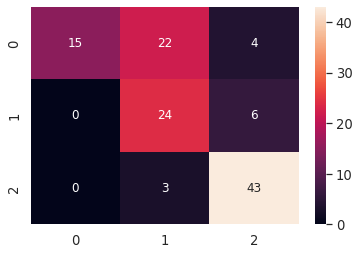

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[ 299.76   474.521  431.911  647.908  490.485  337.483  533.164  793.358
  569.788  445.044  624.837  377.525  462.674  426.749  435.22   502.984
  282.386  470.23   455.147  413.46   358.979  375.022  390.862  959.762
  267.779  323.972  257.593  595.358  518.784  410.356  511.95   334.19
  312.904  365.686  529.574  394.303  456.281 1132.789  267.753  251.923
  540.989  521.746  366.823  392.661  248.931  395.418 1022.746  282.786
  370.286  294.949  307.919  277.603  384.911  273.363  548.439  424.268
  447.218  468.06   317.264  294.245  921.409  341.567  227.747  280.313
  743.065  323.388  261.766  831.875  227.949  553.19   317.637  527.896
  461.932  413.161  397.501  227.798  531.658  498.82   304.024  553.308
  414.676  372.856  515.049  303.604  532.026  438.737  414.925  466.46
  570.038  913.099  458.835  325.754  668.363  274.885  319.354  343.944
  548.619  399.952  634.428  517.8

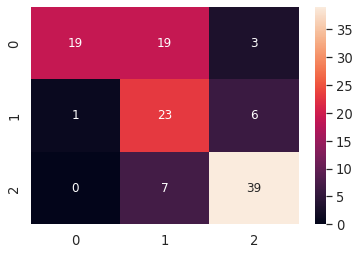

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-1.289 total time=   6.6s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.169 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.543 total time=   0.9s
[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600;, score=-0.246 total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=0.077 total time=   3.1s
[CV 2/3] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.303 total time=   1.0s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=0.030 total time=   3.0s[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.493 total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=0.127 total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=-0.740 total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=-0.932 total time=   2.2s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-0.559 total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=-0.942 total time=   3.0s
[CV 2/3] END bootstrap=False, max_depth=100

[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.540 total time=   6.6s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.168 total time=   0.3s
[CV 1/3] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.367 total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=0.031 total time=   2.3s
[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-1.300 total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=0.094 total time=   2.3s
[CV 3/3] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-1.905 total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=70, mi

[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=-0.487 total time=   8.6s
[CV 1/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.107 total time=   1.8s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.164 total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=0.049 total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.152 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1400;, score=-0.545 total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=0.041 total time=   0.8s
[CV 2/3] END bootstrap=False, max_depth=80, 

[CV 1/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=0.117 total time=   8.6s
[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600;, score=-1.641 total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-0.827 total time=   2.3s
[CV 3/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-1.269 total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.062 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.013 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=0.057 total time=   0.7s
[CV 3/3] END bootstrap=False, max_depth=40, min

[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.261 total time=   6.9s
[CV 3/3] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-1.807 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600;, score=-0.166 total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=0.034 total time=   3.0s
[CV 1/3] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.301 total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.107 total time=   0.7s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=1200;, score=-0.313 total time=   2.8s
[CV 1/3] END bootstrap=False, max_depth=4

[593.106 531.679 632.411 617.496 479.722 360.363 467.034 645.125 493.785
 444.147 602.472 350.088 263.032 371.357 418.079 564.477 389.326 669.723
 411.37  329.803 325.173 353.862 380.902 645.228 380.537 348.906 258.307
 570.738 540.332 635.401 503.443 379.825 249.681 610.824 267.331 644.427
 509.814 861.093 407.923 221.904 599.928 389.929 597.93  317.175 324.128
 355.353 823.57  314.095 353.135 252.743 365.806 259.548 511.388 271.814
 513.614 427.576 510.861 429.119 283.111 402.51  865.999 507.799 205.444
 224.569 666.843 347.549 299.785 780.42  334.43  434.827 342.779 555.06
 498.017 524.367 349.915 272.843 578.668 548.064 396.102 536.256 328.613
 412.158 558.895 286.619 604.089 357.178 350.809 513.758 541.382 712.817
 443.278 404.708 733.289 342.568 260.802 378.346 602.585 379.561 554.906
 499.889 596.659 313.351 508.222 427.086 826.174 432.485 563.308 500.302
 410.496 378.849 365.898 422.633 510.714 314.698 598.085 458.856 310.934]
54445.321373024875 14320.49956550661 124346.6374618

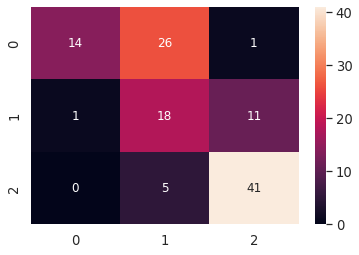

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[515.078 729.527 564.796 529.328 438.294 434.567 560.47  665.304 561.469
 476.239 670.308 345.981 289.709 460.362 371.309 469.55  379.739 662.266
 433.054 312.804 360.585 330.091 389.898 676.76  311.588 340.112 270.339
 670.104 577.018 711.032 499.51  410.768 273.704 517.705 266.645 637.525
 397.879 768.554 420.763 240.67  521.327 402.865 577.188 221.006 299.939
 343.522 811.429 300.379 414.864 256.743 338.949 251.585 485.283 259.985
 687.849 394.242 560.738 406.816 285.074 366.941 849.874 431.118 203.591
 452.482 634.46  346.97  277.155 798.951 316.194 407.05  329.842 490.914
 352.771 436.823 315.694 243.673 550.665 651.697 280.808 465.207 317.437
 348.686 623.488 313.106 527.164 379.491 341.809 568.894 533.892 657.761
 405.282 328.075 646.195 377.048 278.501 323.959 479.26  329.184 544.72
 587.467 725.356 310.268 546.025 351.723 826.514 510.909 604.767 357.655
 368.454 339.548 341.136 532.969 

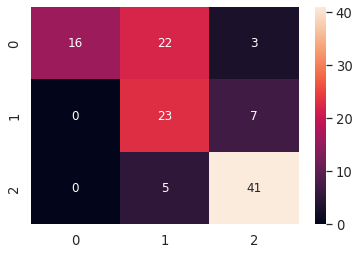

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1600;, score=-0.314 total time=   3.3s
[CV 1/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1800;, score=-0.434 total time=   3.6s
[CV 3/3] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.672 total time=   1.7s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.353 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=-1.182 total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=2, n_estimators=1600;, score=-0.117 total time=   3.4s
[CV 3/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=-0.248 total time=   3.0s
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-2.450 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=-2.430 total time=   3.1s
[CV 1/3] END bootstrap=True, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.261 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=-2.469 total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=-0.881 total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=40, min_samples_leaf=2, min_samples_split=2, n_estimators=1600;, score=-0.479 total time=   3.3s
[CV 3/3] END bootstrap=False, max_depth=8

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=-0.912 total time=   4.1s
[CV 1/3] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=-0.269 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.847 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.271 total time=   0.7s
[CV 3/3] END bootstrap=False, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.876 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-0.976 total time=   4.4s
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.243 total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=60, mi

[CV 3/3] END bootstrap=False, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1400;, score=-0.642 total time=   2.6s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.139 total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=-0.120 total time=   2.4s
[CV 3/3] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=5, n_estimators=1600;, score=-0.671 total time=   3.3s
[CV 3/3] END bootstrap=True, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.095 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=40, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.673 total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-0.128 total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=60, min

[CV 2/3] END bootstrap=True, max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=0.022 total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=0.025 total time=   2.5s
[CV 3/3] END bootstrap=False, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=1400;, score=-0.897 total time=   2.6s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-0.117 total time=   4.4s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=-0.739 total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=1600;, score=0.035 total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.126 total time=   1.6s
[CV 3/3] END bootstrap=False, max_depth=110, min

[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=-1.518 total time=   3.8s[CV 2/3] END bootstrap=False, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=1400;, score=-0.505 total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-0.983 total time=   4.4s
[CV 1/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=2, n_estimators=1400;, score=-0.475 total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=1600;, score=-0.129 total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=0.020 total time=   1.6s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=10, n_estimators=1600;, score=-0.506 total time=   2.8s
[CV 2/3] END bootstrap=True, max_depth=90, m

[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-1.177 total time=   1.7s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.642 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=-0.663 total time=   2.1s
[CV 1/3] END bootstrap=False, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=1400;, score=-0.690 total time=   2.6s
[CV 2/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=0.023 total time=   4.4s
[CV 3/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=2, n_estimators=1400;, score=-0.121 total time=   2.9s
[CV 3/3] END bootstrap=False, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=-0.897 total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=70, m

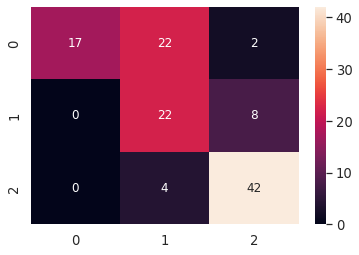

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=-0.141 total time=   4.5s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=-0.129 total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=80, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-0.271 total time=   1.5s
[CV 2/3] END bootstrap=True, max_depth=60, min_samples_leaf=1, min_samples_split=10, n_estimators=1800;, score=0.034 total time=   3.7s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=-0.506 total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=80, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.144 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_es

[ 305.03   521.615  433.895  704.34   458.315  369.77   509.005  885.645
  566.31   436.26   649.625  348.62   367.285  412.965  430.225  497.43
  306.705  500.     406.145  381.715  371.515  284.305  425.17  1025.785
  215.57   284.605  196.615  620.68   582.28   450.975  551.48   310.765
  342.465  353.115  361.72   378.455  435.435 1185.67   337.07   207.925
  497.805  543.45   390.045  381.68   240.54   401.785 1306.805  265.16
  340.94   247.34   275.53   243.87   369.03   191.135  522.08   402.5
  444.805  452.015  335.52   266.65  1107.255  372.005  207.095  212.96
  864.6    308.285  224.07   857.55   176.18   524.04   242.63   462.38
  422.445  420.87   369.13   192.54   529.83   520.98   262.41   539.8
  424.885  378.985  527.765  334.81   626.215  410.905  391.7    448.195
  595.475 1054.23   434.085  258.4    640.165  223.36   261.62   374.185
  591.115  365.595  653.715  515.63   741.37   305.585  544.995  324.135
 1033.945  337.06   867.9    401.41   313.02   318.305  342

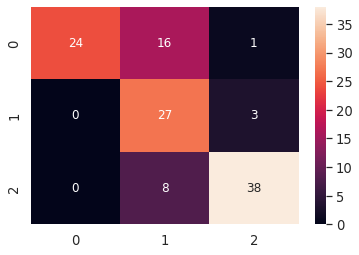

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-0.564 total time=   2.3s
[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.559 total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=-0.255 total time=   3.9s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=-0.700 total time=   3.4s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1800;, score=-1.012 total time=   4.1s
[CV 3/3] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=-1.504 total time=   3.3s
[CV 2/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_

[CV 3/3] END bootstrap=False, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=1400;, score=-1.507 total time=   2.5s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=1200;, score=-0.505 total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-0.240 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-0.782 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.034 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=1400;, score=-0.836 total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=-1.022 total time=   4.4s
[CV 3/3] END bootstrap=True, max_depth=30, mi

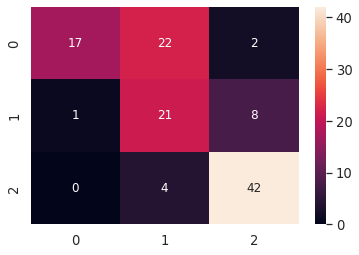

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=-0.196 total time=   3.4s
[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=1600;, score=-0.700 total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.261 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=80, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-0.188 total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=60, min_samples_leaf=1, min_samples_split=10, n_estimators=1800;, score=-0.245 total time=   3.7s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=-0.309 total time=   3.9s
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=10, n_


[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=-0.700 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=1600;, score=0.002 total time=   3.0s
[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=1600;, score=-1.504 total time=   2.9s
[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-2.523 total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=60, min_samples_leaf=1, min_samples_split=10, n_estimators=1800;, score=0.116 total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=-0.730 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=1200;, score=-0.969 total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=50, 

[CV 2/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=-0.110 total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=-0.105 total time=   2.7s
[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-1.283 total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-0.083 total time=   2.5s
[CV 2/3] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.477 total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.038 total time=   0.7s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=1200;, score=-0.776 total time=   2.5s
[CV 1/3] END bootstrap=False, max_depth=40,


[CV 3/3] END bootstrap=True, max_depth=80, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.974 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=-0.960 total time=   4.5s
[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600;, score=-0.183 total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-0.147 total time=   2.4s
[CV 1/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-1.039 total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=-0.056 total time=   2.9s
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-0.689 total time=   1.1s
[CV 1/3] END bootstrap=True, max_de

[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-1.507 total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=-0.085 total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=-0.045 total time=   2.6s
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-1.122 total time=   0.8s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.187 total time=   2.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=-0.099 total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.106 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth

[610.123 531.933 646.003 577.812 445.5   327.053 478.187 631.169 549.403
 469.405 626.997 363.359 250.611 393.857 349.952 526.049 383.719 690.659
 401.511 334.607 337.625 416.499 382.063 670.486 370.397 367.363 276.964
 580.884 545.477 619.797 521.05  428.336 276.484 625.704 288.869 631.552
 501.349 794.608 403.825 232.511 601.805 419.885 586.703 258.094 320.134
 358.584 801.218 344.578 326.898 238.186 376.858 244.961 526.991 290.618
 490.675 456.444 517.534 367.796 300.941 402.053 843.574 501.726 206.733
 219.975 678.017 366.242 324.7   761.506 336.095 469.371 324.264 488.034
 436.784 471.675 375.797 322.518 593.341 546.875 390.395 556.862 327.583
 421.932 486.787 291.363 622.518 373.133 347.369 425.843 522.459 731.61
 449.288 374.705 710.12  276.891 291.662 398.413 613.475 374.336 578.424
 456.564 611.863 315.873 519.332 455.989 818.451 456.635 566.267 457.156
 394.842 380.81  348.58  466.655 472.971 330.475 571.115 461.307 301.906]
55782.90838929599 11269.144758164568 130015.6417943

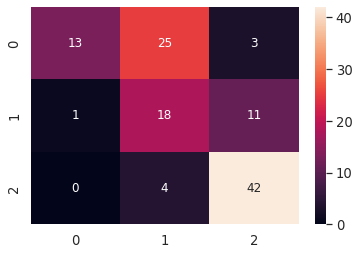

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[330.979 638.599 423.328 544.942 491.381 407.194 556.986 800.932 534.809
 444.054 625.446 294.258 237.807 596.259 453.266 483.691 303.178 521.02
 354.075 351.011 410.597 288.947 364.794 782.909 385.253 475.192 463.026
 641.917 511.905 499.558 446.674 304.754 387.852 460.671 289.067 433.03
 337.83  879.699 401.073 237.564 492.418 845.768 462.289 207.928 263.892
 286.266 871.932 286.097 528.307 251.054 314.16  301.159 461.733 266.263
 496.11  514.392 469.805 456.143 432.742 212.999 819.158 497.149 216.598
 245.512 676.243 284.808 433.869 914.974 319.129 757.115 267.325 480.097
 430.651 456.825 448.29  184.714 656.106 742.78  325.512 507.184 407.802
 384.879 569.322 301.072 569.816 396.905 401.958 339.25  559.009 712.006
 458.039 440.672 542.471 284.066 300.875 249.476 455.07  401.335 600.381
 524.038 760.561 260.376 518.364 297.939 523.1   251.429 744.32  424.895
 476.143 352.727 373.734 683.889 4

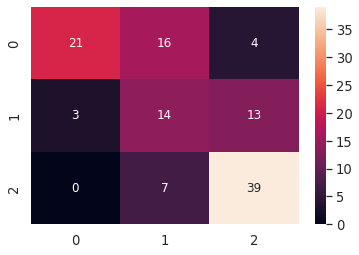

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=0.041 total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=-0.021 total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.396 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=1000;, score=-2.749 total time=   2.1s
[CV 2/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=10, n_estimators=1200;, score=0.065 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.033 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estim

[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.722 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.032 total time=   2.9s
[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-1.032 total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=-0.271 total time=   3.4s
[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600;, score=-0.893 total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-0.086 total time=   2.5s
[CV 3/3] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-1.177 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=20,

[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-1.185 total time=   1.9s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.745 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.812 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1600;, score=-2.402 total time=   3.9s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=-0.108 total time=   3.5s
[CV 3/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-0.587 total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=-0.089 total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=20

[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=-0.399 total time=   5.2s
[CV 1/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=-0.598 total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=-1.129 total time=   3.3s
[CV 1/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-1.144 total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=-0.270 total time=   3.1s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-0.369 total time=   1.3s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1600;, score=-0.567 total time=   3.4s
[CV 3/3] END bootstrap=True, max_depth=

[CV 2/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1800;, score=0.022 total time=   3.6s
[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.422 total time=   1.7s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.484 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=-0.420 total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=-0.007 total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.003 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=1200;, score=-0.339 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=30, mi

[CV 3/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=-0.092 total time=   3.5s
[CV 1/3] END bootstrap=False, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=1400;, score=-0.675 total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-1.012 total time=   4.3s
[CV 3/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=2, n_estimators=1400;, score=-0.082 total time=   3.0s
[CV 3/3] END bootstrap=False, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=-0.893 total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=-0.117 total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=-0.093 total time=   1.9s
[CV 3/3] END bootstrap=False, max_depth=None

[CV 3/3] END bootstrap=True, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.122 total time=   0.5s
[CV 3/3] END bootstrap=False, max_depth=40, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.584 total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-0.088 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=-0.567 total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=-0.067 total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.092 total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.949 total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=30, min_s

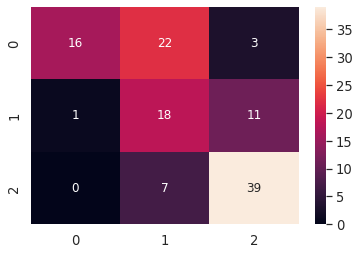

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

mac = 0
fpred = []

for Si in S:
    X_train_ = np.array(prune(x_train,Si))
    X_test_ = np.array(prune(x_test,Si))

    print(X_train_.shape)
    print(X_test_.shape)
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
    # Fit the random search model
    print(X_train_.shape)
    rf_random.fit(X_train_, y_train)
    rf_random.best_params_
    best_grid = rf_random.best_estimator_
    meanSE, medianSE, stdSE, spearmanR, y_pred = evaluate(best_grid, X_train_, y_train)
    print(meanSE, medianSE, stdSE, spearmanR)
    y_pred2=best_grid.predict(X_test_)
    print(y_pred2)
    for hh in y_pred2:
        print(hh)
    y_train_v, y_pred_v = classif(y_train,y_pred)
    cm = confusion_matrix(y_train_v, y_pred_v)
    acc_sc = accuracy_score(y_train_v, y_pred_v)
    print(acc_sc)
    if acc_sc>mac:
        print(f"model updated as training accuracy ={acc_sc} is better than last model which had accracy = {mac}")
        mac = acc_sc
        fpred = y_pred2

    sns.set(font_scale=1.2) 
    sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 
    plt.show()


In [131]:
# import xlsxwriter module
import xlsxwriter

workbook = xlsxwriter.Workbook('./mrmre_e_op.xlsx')
worksheet = workbook.add_worksheet()

# Start from the first cell.
# Rows and columns are zero indexed.
row = 0
column = 0

# iterating through content list
for item in patlist_val :

	# write operation perform
	worksheet.write(row, column, item)

	# incrementing the value of row by one
	# with each iterations.
	row += 1
	
column += 1
row = 0
for item in fpred :

	# write operation perform
	worksheet.write(row, column, item)

	# incrementing the value of row by one
	# with each iterations.
	row += 1

workbook.close()


In [132]:
ll = [patlist_val,fpred]
ab = zip(*ll)

In [133]:
import csv

with open('./mrmre_e_op.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    row_list = list(ab)
    
    writer.writerows(row_list)


[CV 1/3] END bootstrap=False, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=1400;, score=-0.927 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-0.278 total time=   4.4s
[CV 3/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=2, n_estimators=1400;, score=-0.287 total time=   2.9s
[CV 1/3] END bootstrap=False, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=-0.928 total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=-0.120 total time=   2.1s
[CV 1/3] END bootstrap=False, max_depth=100, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.929 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.038 total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=80,

[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-1.714 total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=-0.043 total time=   3.9s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=-0.975 total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1800;, score=-0.114 total time=   3.8s
[CV 1/3] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=-0.976 total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-0.027 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-0.146 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=30, mi